## Peer-graded Assignment: Прогнозирование уровня средней заработной платы в России


In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


### 1  Визуальный анализ ряда

Построим графики данных и STL-декомпозиции ряда.

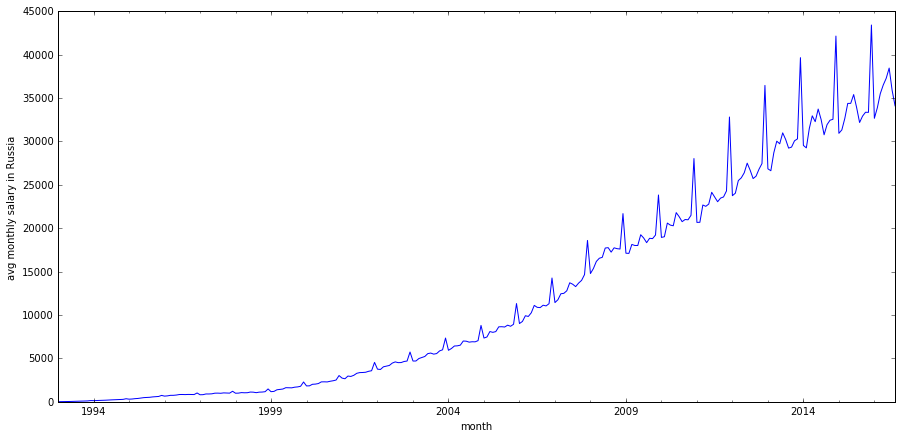

In [3]:
data = pd.read_csv('../WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('avg monthly salary in Russia')
pylab.show()

Результаты STL-декомпозиция ряда
Критерий Дики-Фуллера: p=0.991850


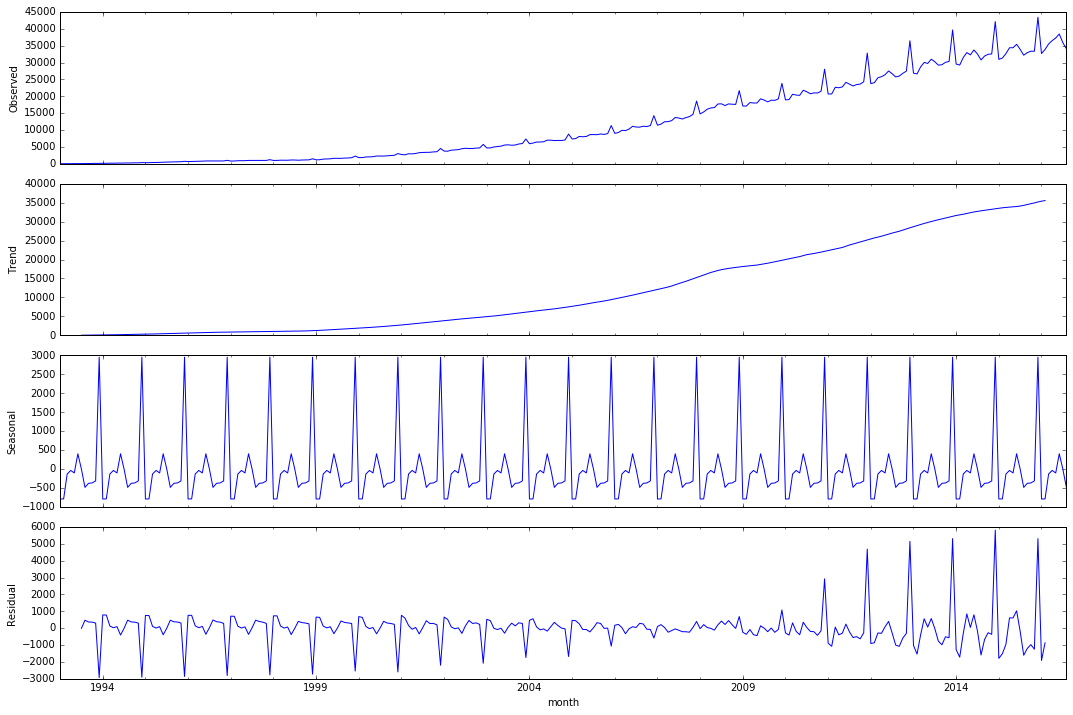

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print 'Результаты STL-декомпозиция ряда'
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1]

По графику данных видно, и соответствующие графики STL-декомпозиции ряда это также подтверждают, что:
* данные имеют выраженный тренд на увеличение;
* данные имеют годовую сезонность с максимумом в декабре каждого года и минимумом - в январе;
* данные имеют разную дисперсию в начале и в конце ряда;
* цикличность не заметна.

Таким образом ряд данных явно не стационарный, что также не противоречит результату критерия Дики-Фуллера.

### 2 Cтабилизация дисперсии
Анализ на предыдущем шаге говорит о том, что необходимо провести стабилизацию дисперсии. Для этого сделаем преобразование Бокса-Кокса.

Оптимальный параметр преобразования Бокса-кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


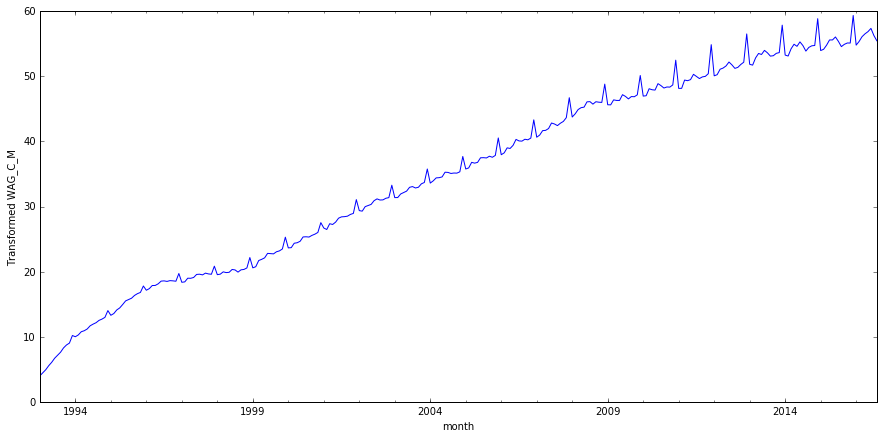

In [5]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.WAG_C_M_box.plot()
plt.ylabel(u'Transformed WAG_C_M')
print "Оптимальный параметр преобразования Бокса-кокса: %f" % lmbda
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1]

Видим, что разброс дисперсии стал меньше. Значение кретирея Дики-Фуддера также стало меньше, однако всё ещё очень большое, чтобы отвегнуть гипотезу нестационарности ряда. Да и к тому же нестационарность по-прежнему наглядно видно на графике. Для достижения стационарности ряда попробуем подобрать параметры дифференгцирования ряда.

### 3 Выбор порядка дифференцирования

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


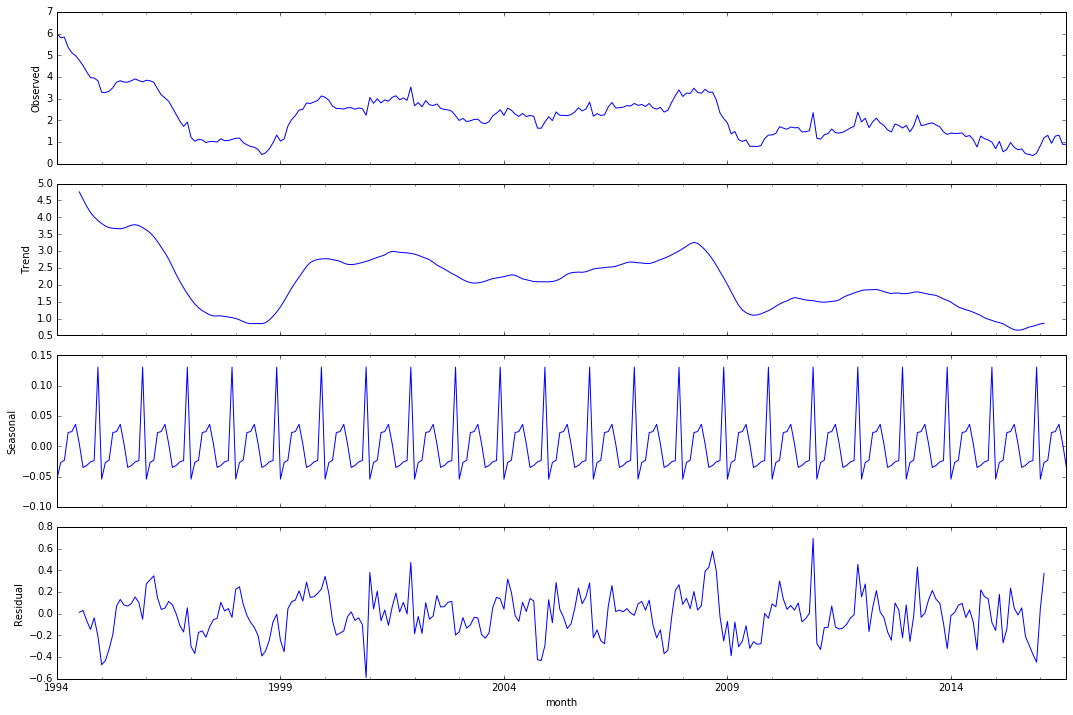

In [5]:
data['WAG_C_M_box_diff'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff[12:]).plot()
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff[12:])[1]

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


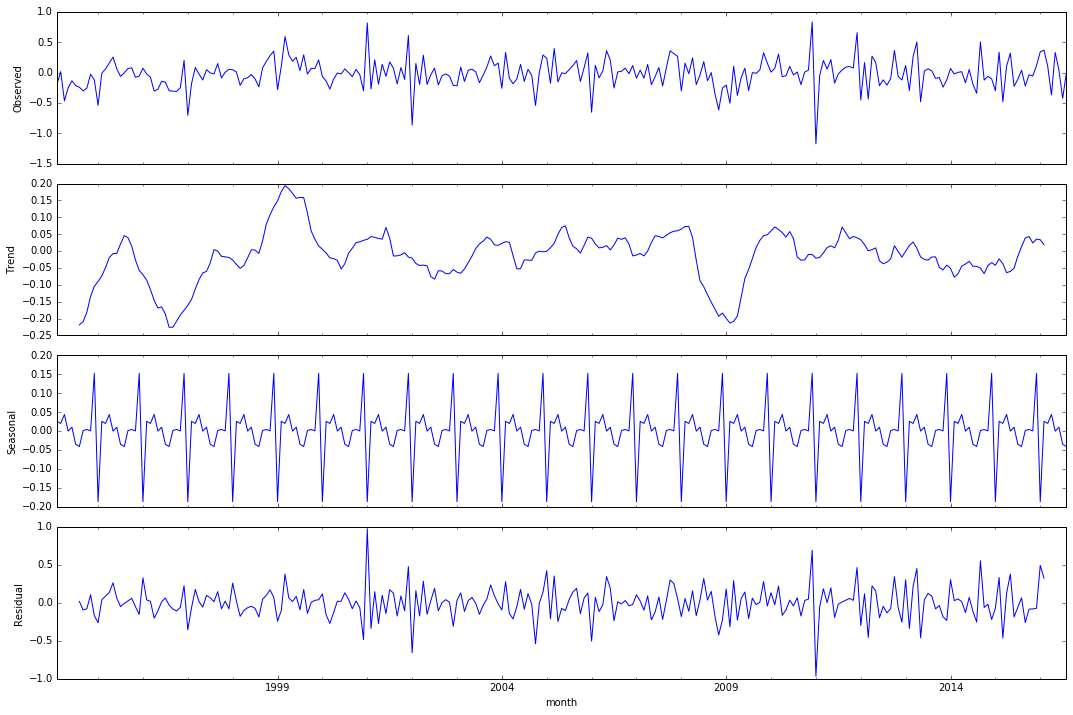

In [6]:
data['WAG_C_M_box_diff2'] = data.WAG_C_M_box_diff - data.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff2[13:]).plot()   
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff2[13:])[1]

Гипотеза нестационарности уверенно отвергается, и визуально ряд выглядит лучше — тренда больше нет. Остатки также получаются не смешенными.

## 4 Выбор начальных приближений для p,q,P,Q

Посмотрим на ACF и PACF полученного ряда:

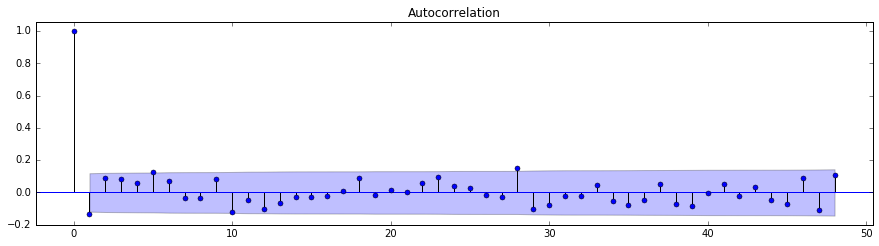

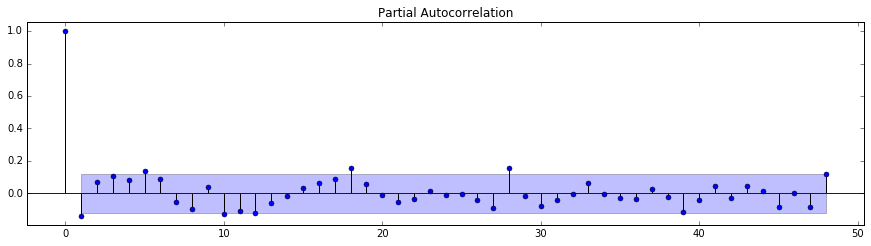

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальное приближение для Q нам дает номер последнего сезонного лага, при котором автокорреляция значима. В данном случае даже при наименьшем сезонном лаге (12 месяцев, т.е. первый сезонный период), мы видим, что автокорреляция находится ниже уровня значимости. Однако набор параметров для перебора у нас получится небольшой, и мы решаем сразу расширить его. Поэтому начальное приближение для Q возьмем равным 1.

Что касается q, его задает номер последнего несезонного лага, при котором автокорреляция значима. В данном случае в качестве начального приближения для q можно взять 1.  

Начальное приближение для P нам задает номер последнего сезонного лага, при котором частичная автокорреляция значима. Для второго сезонного лага (24 месяца) мы видим, что частичная автокорреляция незначима. Поэтому возьмем в качестве начального приближения P возьмем 1.

И наконец, параметр p задается как номер последнего несезонного лага, при котором частичная автокорреляция значима. В нашем случае - 1.
 

Итак, начальные приближения: Q=1, q=1, P=1, p=1

## 5 Обучение и сравнение моделей-кандидатов, выбор победителя

In [8]:
Qs = range(0, 2)
qs = range(0, 2)
Ps = range(0, 2)
ps = range(0, 2)
d=1
D=1

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [9]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print 'wrong parameters:', param
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
Wall time: 4.66 s


In [10]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print result_table.sort_values(by = 'aic', ascending=True).head()

      parameters       aic
9   (1, 0, 1, 0)  0.340521
10  (1, 0, 1, 1)  0.492412
8   (1, 0, 0, 1)  0.774438
5   (0, 1, 1, 0)  1.170768
6   (0, 1, 1, 1)  1.342395


Лучшая модель:

In [11]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Thu, 29 Sep 2016   AIC                              0.341
Time:                                    08:15:13   BIC                             11.287
Sample:                                01-01-1993   HQIC                             4.729
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

## 6 Анализ остатков построенной модели

Критерий Стьюдента: p=0.090792
Критерий Дики-Фуллера: p=0.000003


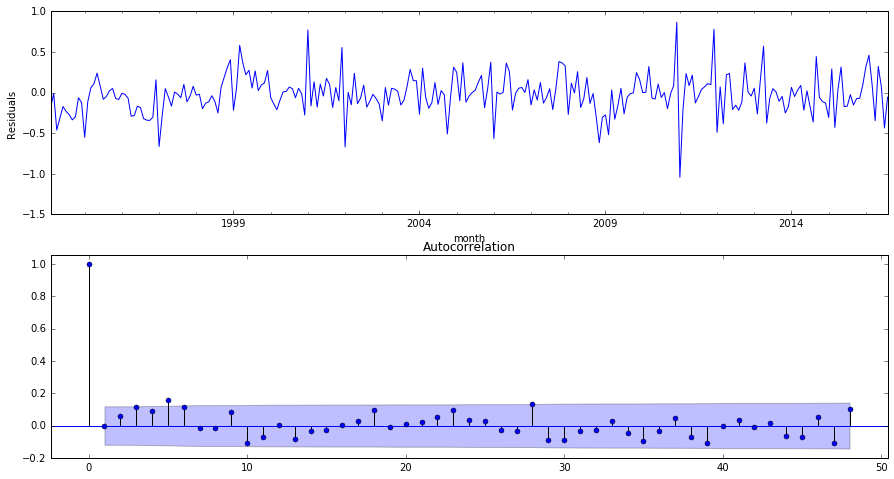

In [12]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print "Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1]
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1]

Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием *Льюнга-Бокса* и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

In [13]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

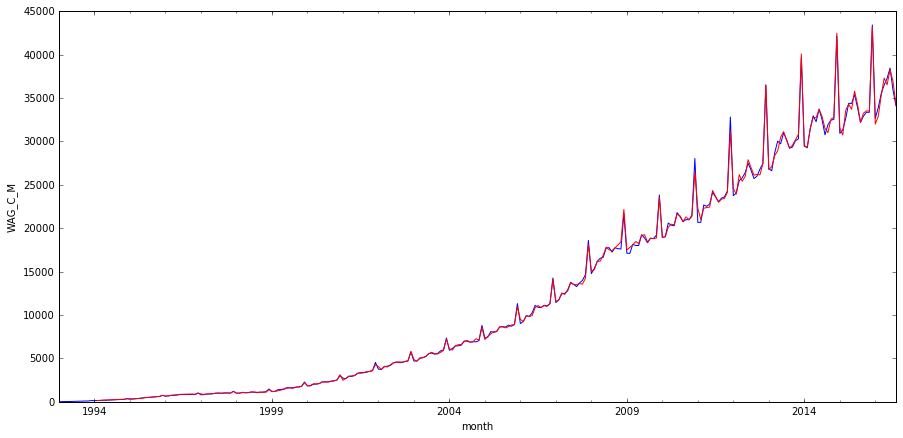

In [14]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()

На графзначения синим цветом показаны значения ряда, красным - значения модели. Видим, что модель достаточно точно описывает исходный ряд.

## 7 Прогнозирование с помощью финальной модели.

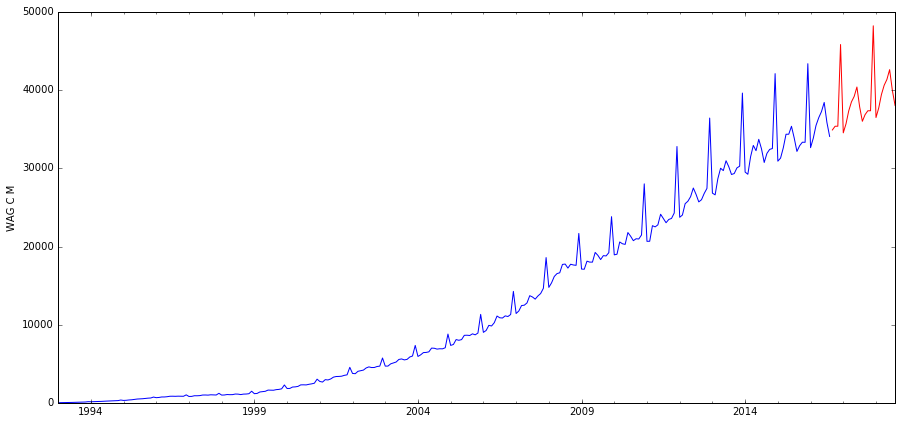

In [15]:
months_to_forecast = 24
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,months_to_forecast)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=284+months_to_forecast), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('WAG C M')
pylab.show()

На графике красным цветом показан прогноз на 24 месяца вперёд. Прогноз выглядит логичным. Видно, что учтён общий повышающийся тренд, сезонность и увеличение дисперсии.